<a href="https://colab.research.google.com/github/Trulete/PIA/blob/main/Churn_Red_Neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#dataset
#https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [2]:
import pandas as pd

# Preparación de los datos

In [ ]:
df = pd.read_csv('Churn.csv')
print(len(df))
df.head().T

In [ ]:
df.dtypes

In [5]:
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,0.0
753,3115-CZMZD,0.0
936,5709-LVOEQ,0.0
1082,4367-NUYAO,0.0
1340,1371-DWPAZ,0.0
3331,7644-OMVMY,0.0
3826,3213-VVOLG,0.0
4380,2520-SGTTA,0.0
5218,2923-ARZLG,0.0
6670,4075-WKNIU,0.0


In [ ]:
replacer = lambda str: str.lower().str.replace(' ', '_')
df.columns = replacer(df.columns.str)
for col in list(df.dtypes[df.dtypes == 'object'].index):
    df[col] = replacer(df[col].str)
df.head().T

In [ ]:
df.churn = (df.churn == 'yes').astype(int)
df.churn.head()

In [ ]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
                'phoneservice', 'multiplelines', 'internetservice',
                'onlinesecurity', 'onlinebackup', 'deviceprotection',
                'techsupport', 'streamingtv', 'streamingmovies',
                'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']
df[categorical].nunique()

In [ ]:
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)
y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

df_train.head().T

# Análisis de la importancia de las propiedades

In [10]:
global_mean = df_train_full.churn.mean()
round(global_mean, 3)

0.27

In [11]:
female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
print(round(female_mean, 3))
male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print(round(male_mean, 3))

0.277
0.263


In [12]:
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
print(round(partner_yes, 3))
partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()
print(round(partner_no, 3))

0.205
0.33


In [ ]:
from sklearn.metrics import mutual_info_score

calculate_mi = lambda col: mutual_info_score(col, df_train_full.churn)

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

In [ ]:
print(df_train_full[numerical].corrwith(df_train_full.churn))

print(round(df_train_full[df_train_full.tenure <= 2].churn.mean(), 3))
print(round(df_train_full[(df_train_full.tenure > 3) & 
                          (df_train_full.tenure <= 12)].churn.mean(), 3))
print(round(df_train_full[df_train_full.tenure > 12].churn.mean(), 3))

print(round(df_train_full[df_train_full.monthlycharges < 20].churn.mean(), 3))
print(round(df_train_full[(df_train_full.monthlycharges > 21) & 
                          (df_train_full.monthlycharges <= 50)].churn.mean(), 3))
print(round(df_train_full[df_train_full.monthlycharges > 50].churn.mean(), 3))

# Ingeniería de propiedades

In [ ]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
dict(sorted(train_dict[0].items()))

In [ ]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

In [ ]:
X_train = dv.transform(train_dict)
X_train[0]

In [ ]:
dv.get_feature_names_out()

# Entrenamiento del modelo

In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [20]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)
y_pred

array([[0.99142714, 0.00857286],
       [0.79028712, 0.20971288],
       [0.78364454, 0.21635546],
       ...,
       [0.35664296, 0.64335704],
       [0.81055916, 0.18944084],
       [0.87261929, 0.12738071]])

In [21]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.00857286, 0.20971288, 0.21635546, ..., 0.64335704, 0.18944084,
       0.12738071])

In [22]:
churn = y_pred >= 0.5
churn

array([False, False, False, ...,  True, False, False])

In [23]:
# precisión del modelo con los datos de entrenamiento
round((y_val == churn).mean(), 3) 

0.805

# Modelo

In [ ]:
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)
y_pred

# Red Neuronal

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [63]:
len(X_train[0])

45

In [ ]:
# define the keras model
modelnn = Sequential()
modelnn.add(Dense(3, input_shape=(len(X_train[0]),), activation='relu'))
# modelnn.add(Dense(8, input_shape=(12,8), activation='relu'))
modelnn.add(Dense(1, input_shape=(6,), activation='sigmoid'))

modelnn.summary()

In [87]:

modelnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history =modelnn.fit(X_train, y_train, epochs=500, batch_size=384)

In [79]:
loss, accuracy  = modelnn.evaluate(X_val, y_val)
print('Accuracy: %.2f' % (accuracy*100))

59/59 [==============================] - 1s 7ms/step - loss: 0.4376 - accuracy: 0.8016
Accuracy: 80.16


In [58]:
modelnn.history

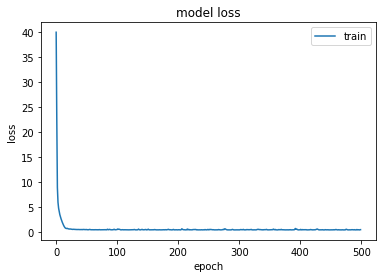

In [80]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

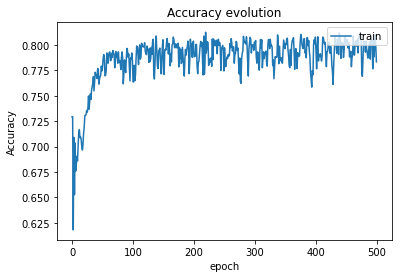

In [81]:
# summarize history for loss
plt.plot(history.history['accuracy'])
plt.title('Accuracy evolution')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

# Red Neuronal con 2 Salidas

In [122]:
y_train

array([0, 1, 0, ..., 1, 0, 1])

In [123]:
df = pd.DataFrame(y_train, columns = ['churn'])

In [128]:
dossalidas = pd.get_dummies(df['churn'])

In [135]:
dossalidas

,0,1
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
3769,1,0
3770,1,0
3771,0,1
3772,1,0


In [139]:
primera = dossalidas[0]
segunda = dossalidas[1]

In [140]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense

input_layer = Input(shape=((len(X_train[0]),)))
hidden_layer = Dense(2, activation='relu')(input_layer)
output_layer_1 = Dense(1, activation='sigmoid')(hidden_layer)
output_layer_2 = Dense(1, activation='sigmoid')(hidden_layer)

In [169]:
model = Sequential()
model.add(Dense(12, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history =model.fit(X_train, dossalidas, epochs=500, batch_size=256)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 12)                552       
                                                                 
 dense_47 (Dense)            (None, 8)                 104       
                                                                 
 dense_48 (Dense)            (None, 2)                 18        
                                                                 
Total params: 674
Trainable params: 674
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
15/15 [==============================] - 1s 3ms/step - loss: 164.3983 - accuracy: 0.2705
Epoch 2/500
15/15 [==============================] - 0s 2ms/step - loss: 81.7460 - accuracy: 0.2705
Epoch 3/500
15/15 [==============================] - 0s 2ms/step - loss: 13.7901 - accuracy: 0.4997
Epoch 4/500
15/15 

In [166]:
model2 = Model(inputs=input_layer, outputs=[output_layer_1, output_layer_2])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 dense_34 (Dense)               (None, 2)            92          ['input_3[0][0]']                
                                                                                                  
 dense_35 (Dense)               (None, 1)            3           ['dense_34[0][0]']               
                                                                                                  
 dense_36 (Dense)               (None, 1)            3           ['dense_34[0][0]']               
                                                                                            

In [142]:
model2.compile(loss=['binary_crossentropy', 'binary_crossentropy'], 
              optimizer='adam', 
              metrics=['accuracy'])

In [155]:
model2.fit(X_train, [primera, segunda], epochs=500, batch_size=256)

Epoch 1/500
15/15 [==============================] - 0s 6ms/step - loss: 1.1676 - dense_35_loss: 0.5838 - dense_36_loss: 0.5838 - dense_35_accuracy: 0.7295 - dense_36_accuracy: 0.7295
Epoch 2/500
15/15 [==============================] - 0s 6ms/step - loss: 1.1676 - dense_35_loss: 0.5838 - dense_36_loss: 0.5838 - dense_35_accuracy: 0.7295 - dense_36_accuracy: 0.7295
Epoch 3/500
15/15 [==============================] - 0s 6ms/step - loss: 1.1676 - dense_35_loss: 0.5838 - dense_36_loss: 0.5838 - dense_35_accuracy: 0.7295 - dense_36_accuracy: 0.7295
Epoch 4/500
15/15 [==============================] - 0s 6ms/step - loss: 1.1676 - dense_35_loss: 0.5838 - dense_36_loss: 0.5838 - dense_35_accuracy: 0.7295 - dense_36_accuracy: 0.7295
Epoch 5/500
15/15 [==============================] - 0s 5ms/step - loss: 1.1676 - dense_35_loss: 0.5838 - dense_36_loss: 0.5838 - dense_35_accuracy: 0.7295 - dense_36_accuracy: 0.7295
Epoch 6/500
15/15 [==============================] - 0s 6ms/step - loss: 1.1676 

In [171]:
y_pr = model.predict(X_val)
y_pr

59/59 [==============================] - 0s 7ms/step


array([[0.9957859 , 0.00273802],
       [0.6039352 , 0.39111722],
       [0.6135533 , 0.3844022 ],
       ...,
       [0.46241134, 0.5310213 ],
       [0.89826506, 0.09524012],
       [0.9346857 , 0.06308111]], dtype=float32)

In [172]:
display(dossalidas)

,0,1
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
3769,1,0
3770,1,0
3771,0,1
3772,1,0
